## treatment effects

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(survival)))
suppressWarnings(suppressMessages(library(survminer)))

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /usr/local/app/rcs_bin/grid3/envs/rcs_2022.01/lib/libmkl_rt.so.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] survminer_0.4.9 ggpubr_0.4.0    survival_3.2-13 caret_6.0-90   
 [5] lattice_0.20-45 forcats_0.5.1   stringr_1.4.0   dplyr_1.0.7    
 [9] purrr_0.3.4     readr_2.1.2     tidyr_1.2.0     tibble_3.1.6   
[13] ggplot2_3.3.5   tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] colo

In [3]:
dir_path = '/export/projects2/jeryang_narrative_project/globe/log'
setwd(dir_path)

In [4]:
df1 = read.csv('./df_exp1.csv') # first experiment
df2 = read.csv('./df_exp2.csv') # second experiment 

In [5]:
df1$weights_ate = ifelse(df1$treated==1,1/df1$p_treated, 1/(1-df1$p_treated))
df1$weights_att = ifelse(df1$treated==1,1,df1$p_treated/(1-df1$p_treated))
df2$weights_ate = ifelse(df2$treated==1,1/(df2$prob/6),1/(1-df2$prob))
df2$weights_att = ifelse(df2$treated==1,1,(df2$prob/6)/(1-df2$prob))

### first experiment 

#### figure D.3: survival curve

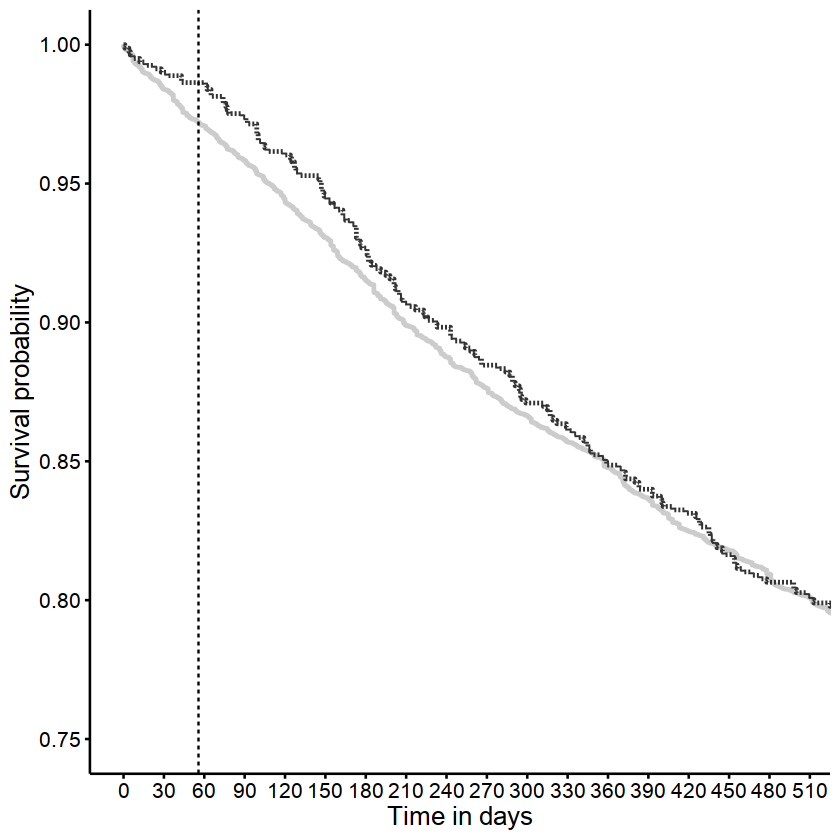

In [6]:
fit <- survfit(Surv(time, churn) ~ treated, data = df1,
              weights = weights_att)

ggsurvplot(fit, linetype = "strata", 
           palette = "grey",
           ylim = c(0.75, 1),
           font.x = c(15),
           font.y = c(15),
           legend = 'none',
           break.x.by = 30,
           xlab = "Time in days")$plot + geom_vline(xintercept = 56, linetype = 'dashed')

#### figure D.4: treatment effects on churn

In [7]:
t = 18 # look at treatment effects over 18 months

start_date = as.Date('2018-08-23')
last_update = as.Date('2020-02-11')

df1$last_stop_date = as.Date(df1$last_stop_date)

In [8]:
ate = data.frame(matrix(ncol = 3, nrow = 0))
colnames(ate) = c('time','effect','se')

att = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att) = c('time','effect','se')

att_top = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att_top) = c('time','effect','se')

In [9]:
for(i in 1:t) { 
    
    data = df1
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    ate[i,2:3] = summary(lm(churn~treated,
           data=data,
           weights=weights_ate))$coefficients[2,1:2] %>% as.numeric
    ate[i,1] = i
    
    att[i,2:3] = summary(lm(churn~treated,
           data=data,
           weights=weights_att))$coefficients[2,1:2] %>% as.numeric
    att[i,1] = i    
    
    
}

for (i in 1:t) {
    
    data = df1
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    data = filter(data, risk_score >= quantile(risk_score,0.9))
    
    att_top[i,2:3] = summary(lm(churn~treated,
           data= data,
           weights=weights_att))$coefficients[2,1:2] %>% as.numeric
    att_top[i,1] = i   
    
}

In [10]:
ate$group = 'ATE'
att$group = 'ATT'
att_top$group = 'ATT: top decile'

te = rbind(ate,att,att_top)

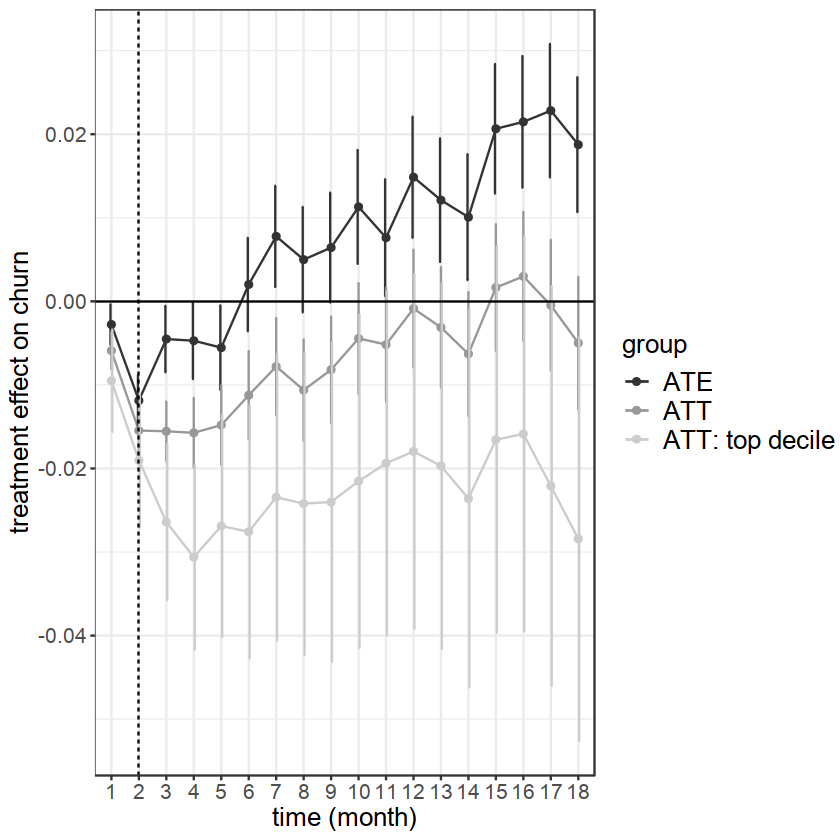

In [11]:
ggplot(te, 
       aes(time,effect,group=group, color=group)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:18))) + 
xlab('time (month)')+
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 15), 
      legend.text = element_text(size = 15))   

#### figure D.5: treatment effects on revenue 

In [12]:
start_date = as.Date('2018-08-23')
last_update = as.Date('2020-02-11')

regular = 6.93 # regular price
discounted = 4.99 # discounted price 

In [13]:
ate = data.frame(matrix(ncol = 3, nrow = 0))
colnames(ate) = c('time','effect','se')

att = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att) = c('time','effect','se')

att_top = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att_top) = c('time','effect','se')

In [14]:
for(i in 1:t) {
    
    data = df1
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = ifelse(churn==0,
                                ifelse(treated==0,regular/7*(last_update-start_date),
                                      regular/7*(last_update-start_date)-(regular-discounted)*8),
                                ifelse(last_stop_date-start_date>= 7*8,
                                             regular/7*(last_stop_date-start_date)-(regular-discounted)*8,
                                             discounted/7*(last_stop_date-start_date))))
    
    ate[i,2:3] = summary(lm(rev~treated,
           data=data,
           weights=weights_ate))$coefficients[2,1:2] %>% as.numeric
    ate[i,1] = i
    
    att[i,2:3] = summary(lm(rev~treated,
           data=data,
           weights=weights_att))$coefficients[2,1:2] %>% as.numeric
    att[i,1] = i    
}

for (i in 1:t) {
    
    data = df1
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    data = filter(data, risk_score >= quantile(risk_score,0.9))
    
    data = data %>% mutate(rev = ifelse(churn==0,
                                ifelse(treated==0,regular/7*(last_update-start_date),
                                      regular/7*(last_update-start_date)-(regular-discounted)*8),
                                ifelse(last_stop_date-start_date>= 7*8,
                                             regular/7*(last_stop_date-start_date)-(regular-discounted)*8,
                                             discounted/7*(last_stop_date-start_date))))
    
    att_top[i,2:3] = summary(lm(rev~treated,
           data= data,
           weights=weights_att))$coefficients[2,1:2] %>% as.numeric
    att_top[i,1] = i   
    
}

In [15]:
ate$group = 'ATE'
att$group = 'ATT'
att_top$group = 'ATT: top decile'

te = rbind(ate,att,att_top)

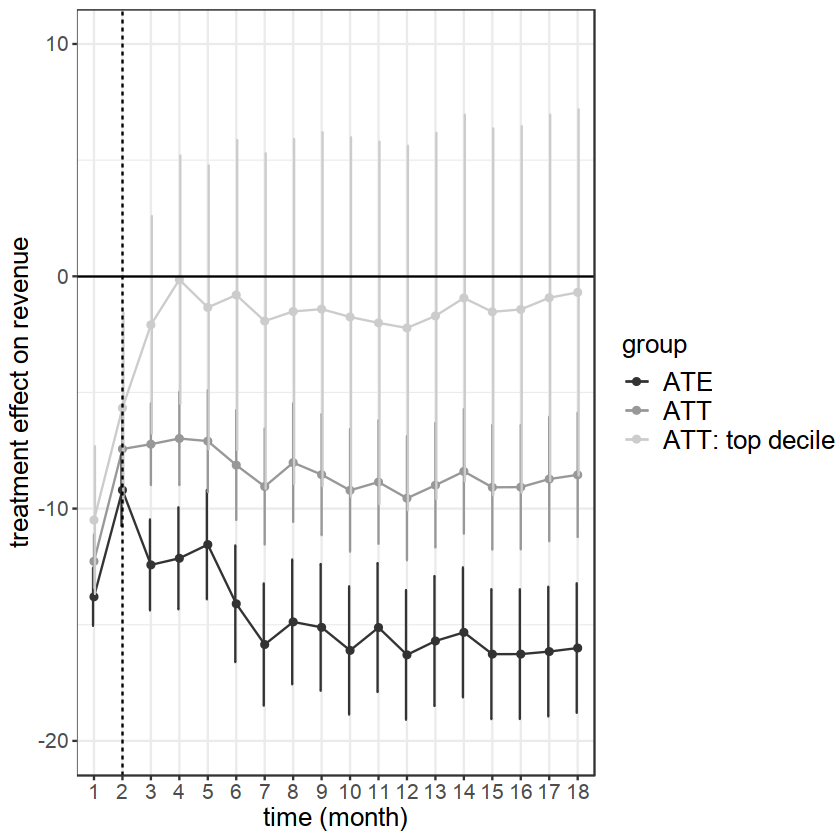

In [16]:
ggplot(te, 
       aes(time,effect,group=group, color=group)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:18))) + 
ylim(c(-20,10))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() +
theme(axis.title = element_text(size = 15), 
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 15), 
      legend.text = element_text(size = 15))   

### second experiment

In [17]:
table(df2$condition)


       $3.99/8 weeks        $4.99/8 weeks        $5.99/4 weeks 
                 953                  938                  945 
       $5.99/8 weeks              control            gift card 
                 956                89866                  937 
thank you email only 
                 959 

In [18]:
df2 <- within(df2, condition <- relevel(as.factor(condition), ref = 'control'))

#### figure D.6: survival curve

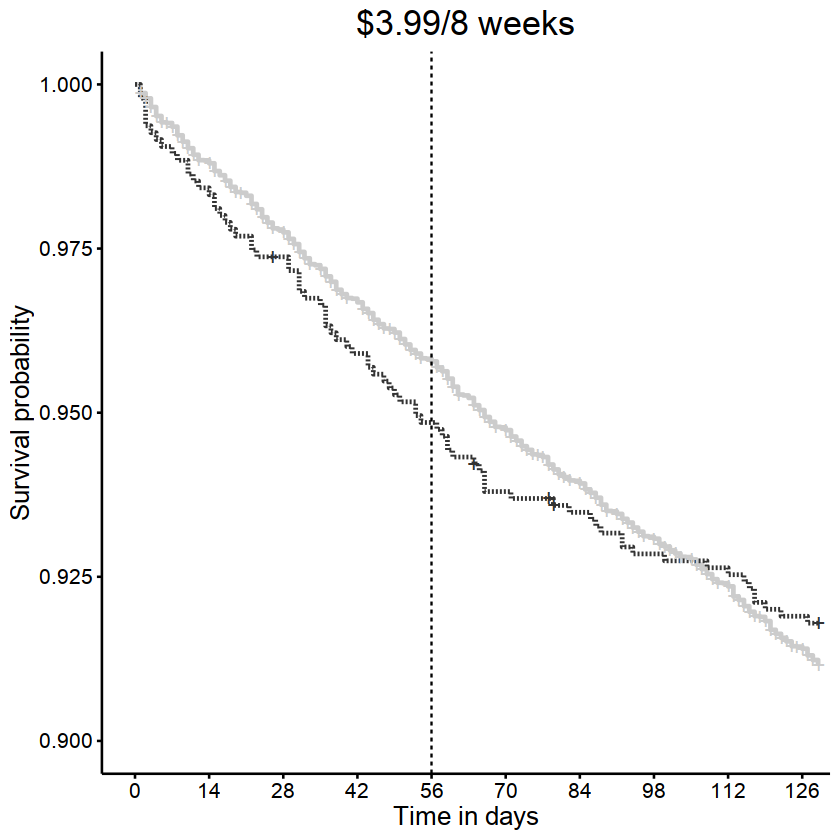

In [19]:
# $3.99/8 weeks vs. control 

fit <- survfit(Surv(time, churn) ~ condition, 
               data = filter(df2, condition == 'control'|condition == '$3.99/8 weeks', time > 0),
               weights = weights_att)

p = ggsurvplot(fit, 
           linetype = "strata", 
           palette = "grey",
           ylim = c(0.9,1),
           font.x = c(15),
           font.y = c(15),
            legend = "none",
           break.x.by = 14,
           xlab = "Time in days")$plot + 
geom_vline(xintercept = 56, linetype = 'dashed') +
ggtitle('$3.99/8 weeks')+ 
theme(plot.title = element_text(hjust = 0.5))+
theme(plot.title = element_text(size = 20))

suppressWarnings(print(p))

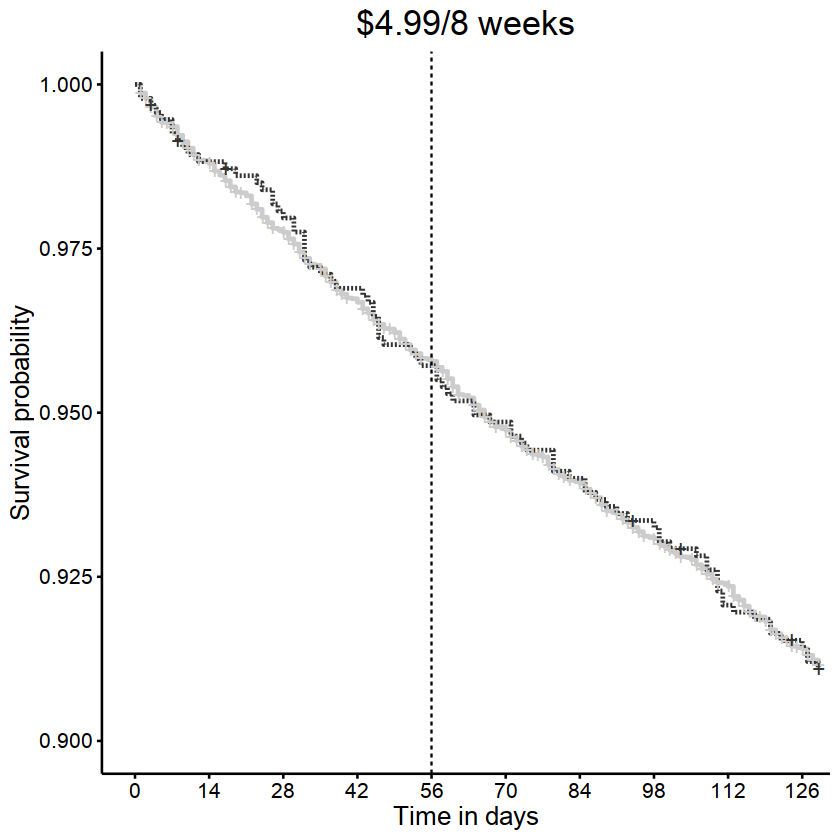

In [20]:
# $4.99/8 weeks vs. control 

fit <- survfit(Surv(time, churn) ~ condition, 
               data = filter(df2, condition == 'control'|condition == '$4.99/8 weeks', time > 0),
               weights = weights_att)

p = ggsurvplot(fit, 
           linetype = "strata", 
           palette = "grey",
           ylim = c(0.9,1),
           font.x = c(15),
           font.y = c(15),
            legend = "none",
           break.x.by = 14,
           xlab = "Time in days")$plot + 
geom_vline(xintercept = 56, linetype = 'dashed') +
ggtitle('$4.99/8 weeks')+ 
theme(plot.title = element_text(hjust = 0.5))+
theme(plot.title = element_text(size = 20))

suppressWarnings(print(p))

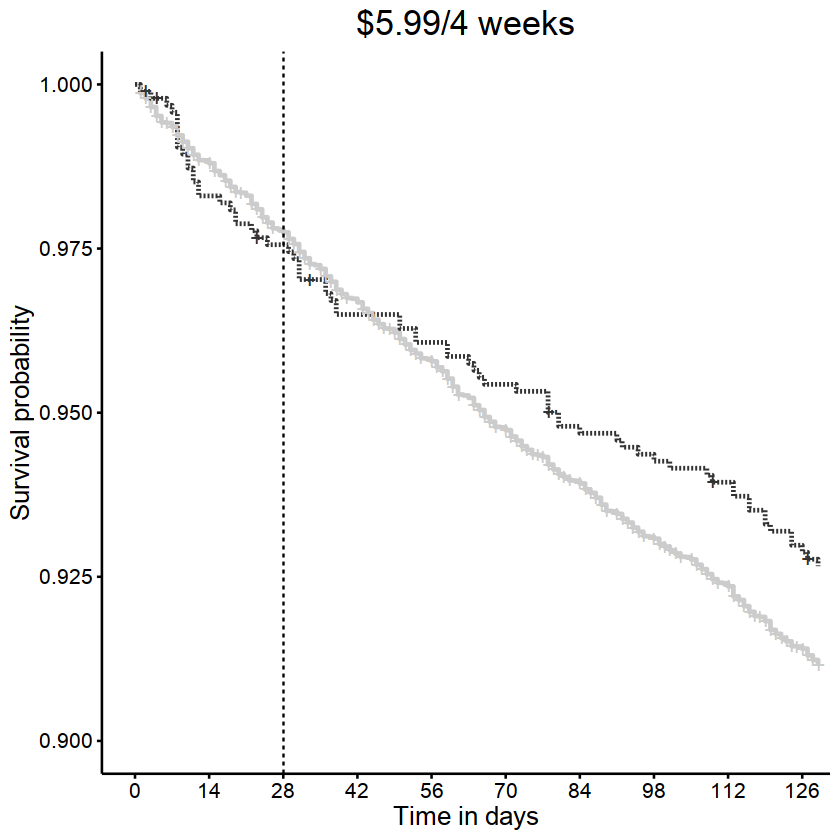

In [21]:
# $5.99/4 weeks vs. control 

fit <- survfit(Surv(time, churn) ~ condition, 
               data = filter(df2, condition == 'control'|condition == '$5.99/4 weeks', time > 0),
               weights = weights_att)

p = ggsurvplot(fit, 
           linetype = "strata", 
           palette = "grey",
           ylim = c(0.9,1),
           font.x = c(15),
           font.y = c(15),
            legend = "none",
           break.x.by = 14,
           xlab = "Time in days")$plot + 
geom_vline(xintercept = 28, linetype = 'dashed') +
ggtitle('$5.99/4 weeks')+ 
theme(plot.title = element_text(hjust = 0.5))+
theme(plot.title = element_text(size = 20))

suppressWarnings(print(p))

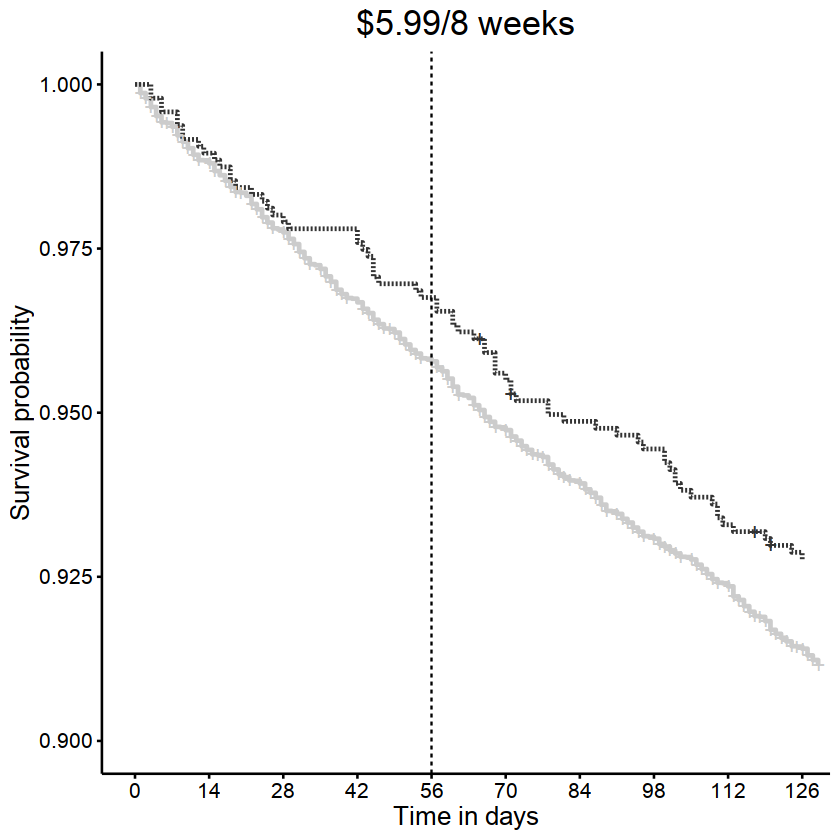

In [22]:
# $5.99/8 weeks vs. control 

fit <- survfit(Surv(time, churn) ~ condition, 
               data = filter(df2, condition == 'control'|condition == '$5.99/8 weeks', time > 0),
               weights = weights_att)

p = ggsurvplot(fit, 
           linetype = "strata", 
           palette = "grey",
           ylim = c(0.9,1),
           font.x = c(15),
           font.y = c(15),
            legend = "none",
           break.x.by = 14,
           xlab = "Time in days")$plot + 
geom_vline(xintercept = 56, linetype = 'dashed') +
ggtitle('$5.99/8 weeks')+ 
theme(plot.title = element_text(hjust = 0.5))+
theme(plot.title = element_text(size = 20))

suppressWarnings(print(p))

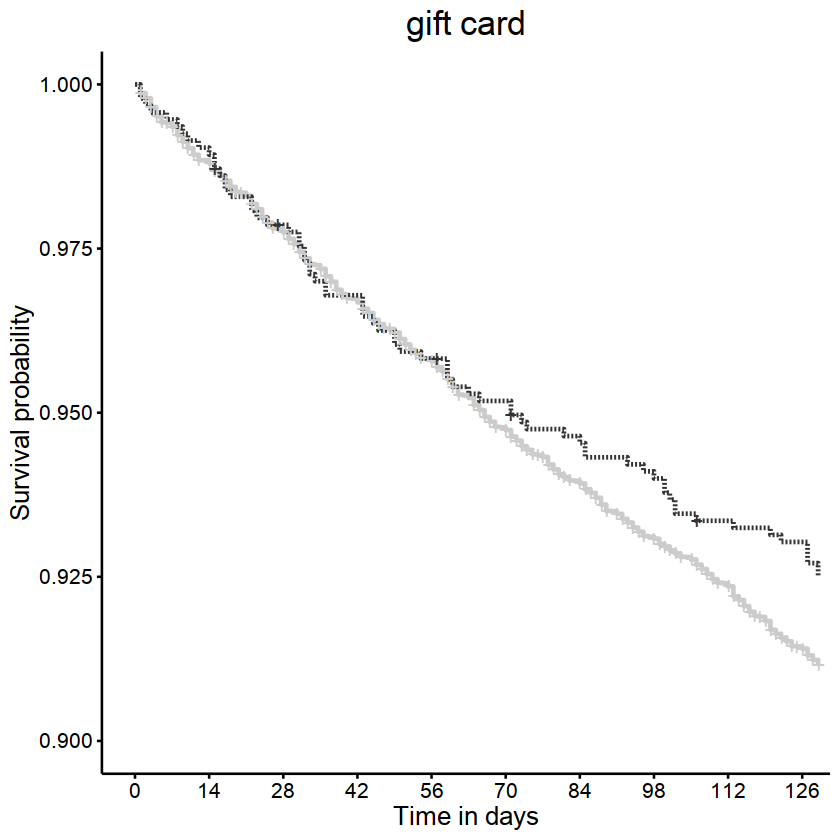

In [23]:
# gift card vs. control 

fit <- survfit(Surv(time, churn) ~ condition, 
               data = filter(df2, condition == 'control'|condition == 'gift card', time > 0),
               weights = weights_att)

p = ggsurvplot(fit, 
           linetype = "strata", 
           palette = "grey",
           ylim = c(0.9,1),
           font.x = c(15),
           font.y = c(15),
            legend = "none",
           break.x.by = 14,
           xlab = "Time in days")$plot + 
ggtitle('gift card')+ 
theme(plot.title = element_text(hjust = 0.5))+
theme(plot.title = element_text(size = 20))

suppressWarnings(print(p))

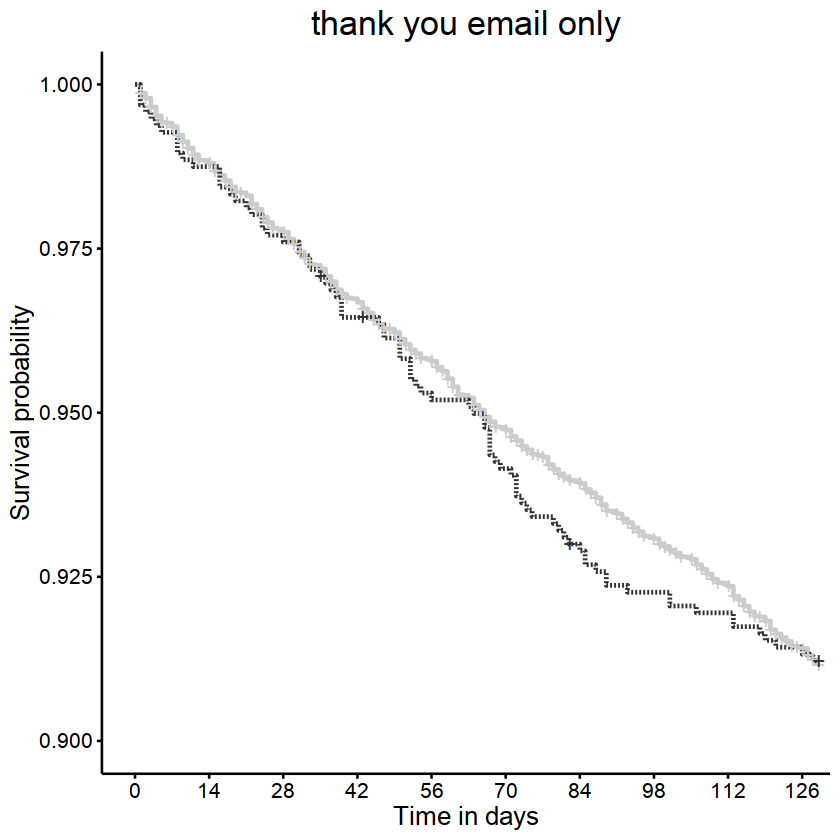

In [24]:
# thank you email only vs. control 

fit <- survfit(Surv(time, churn) ~ condition, 
               data = filter(df2, condition == 'control'|condition == 'thank you email only', time > 0),
               weights = weights_att)

p = ggsurvplot(fit, 
           linetype = "strata", 
           palette = "grey",
           ylim = c(0.9,1),
           font.x = c(15),
           font.y = c(15),
            legend = "none",
           break.x.by = 14,
           xlab = "Time in days")$plot + 
ggtitle('thank you email only')+ 
theme(plot.title = element_text(hjust = 0.5))+
theme(plot.title = element_text(size = 20))

suppressWarnings(print(p))

#### figure D.7: treatment effets on churn

In [25]:
t = 6 # look at treatment effects over 6 months

start_date = as.Date('2019-07-15')
last_update = as.Date('2020-02-11')

df2$last_stop_date = as.Date(df2$last_stop_date)

In [26]:
table(df2$condition)


             control        $3.99/8 weeks        $4.99/8 weeks 
               89866                  953                  938 
       $5.99/4 weeks        $5.99/8 weeks            gift card 
                 945                  956                  937 
thank you email only 
                 959 

In [27]:
df2 <- within(df2, condition <- relevel(as.factor(condition), ref = 'control'))

In [28]:
# $3.99/8 weeks vs. control

att2 = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2) = c('time','effect','se')

cond = c('$3.99/8 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    att2[i,2:3] = summary(lm(churn ~ condition, 
           data = data,
           weights = weights_att))$coefficients[2,1:2] 
    att2[i,1] = i
    
    
}

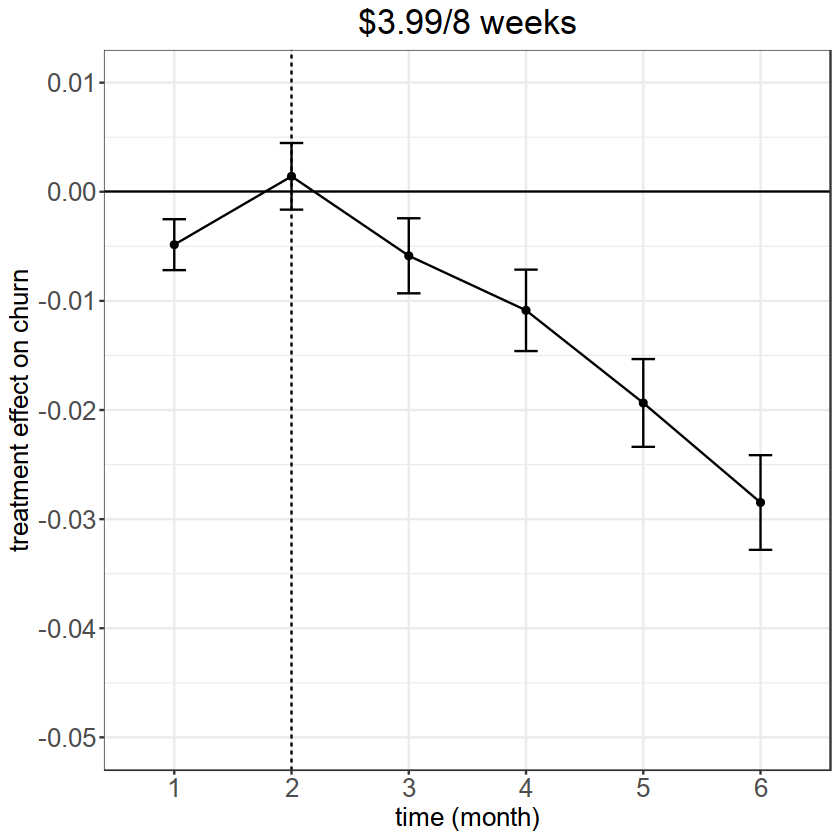

In [29]:
ggplot(att2, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_y_continuous(breaks=seq(-0.05,0.01,0.01),limits=c(-0.05,0.01)) + 
ggtitle('$3.99/8 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size=20), 
      axis.text = element_text(size = 15))   

In [30]:
# $4.99/8 weeks vs. control

att2 = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2) = c('time','effect','se')

cond = c('$4.99/8 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    att2[i,2:3] = summary(lm(churn ~ condition, 
           data = data,
           weights = weights_att))$coefficients[2,1:2] 
    att2[i,1] = i
    
    
}

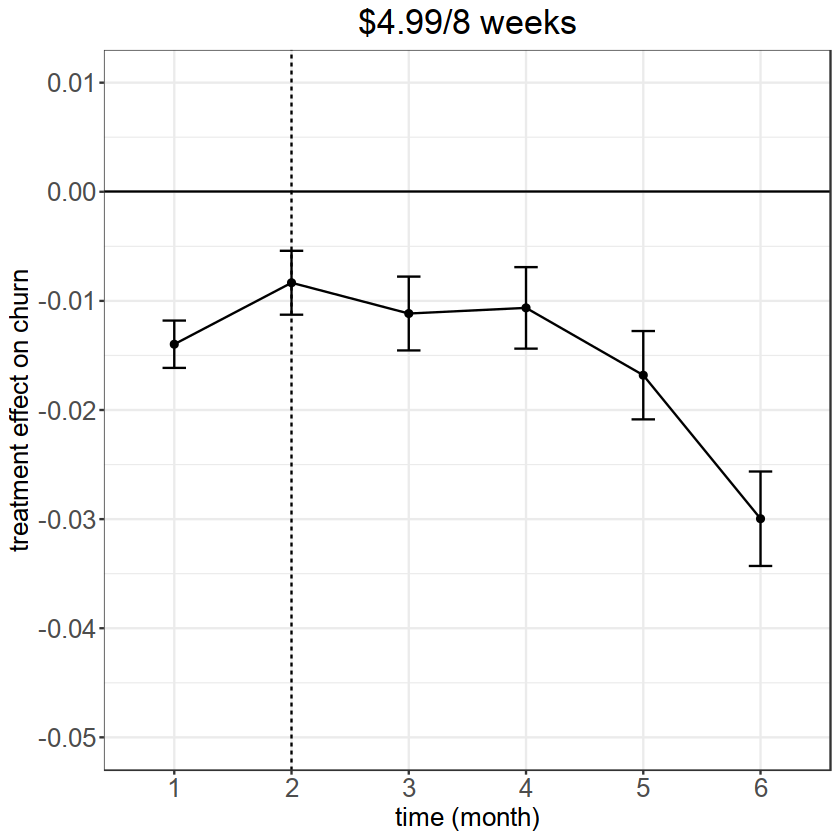

In [31]:
ggplot(att2, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_y_continuous(breaks=seq(-0.05,0.01,0.01),limits=c(-0.05,0.01)) + 
ggtitle('$4.99/8 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size=20), 
      axis.text = element_text(size = 15))  

In [32]:
# $5.99/4 weeks vs. control

att2 = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2) = c('time','effect','se')

cond = c('$5.99/4 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    att2[i,2:3] = summary(lm(churn ~ condition, 
           data = data,
           weights = weights_att))$coefficients[2,1:2] 
    att2[i,1] = i
    
    
}

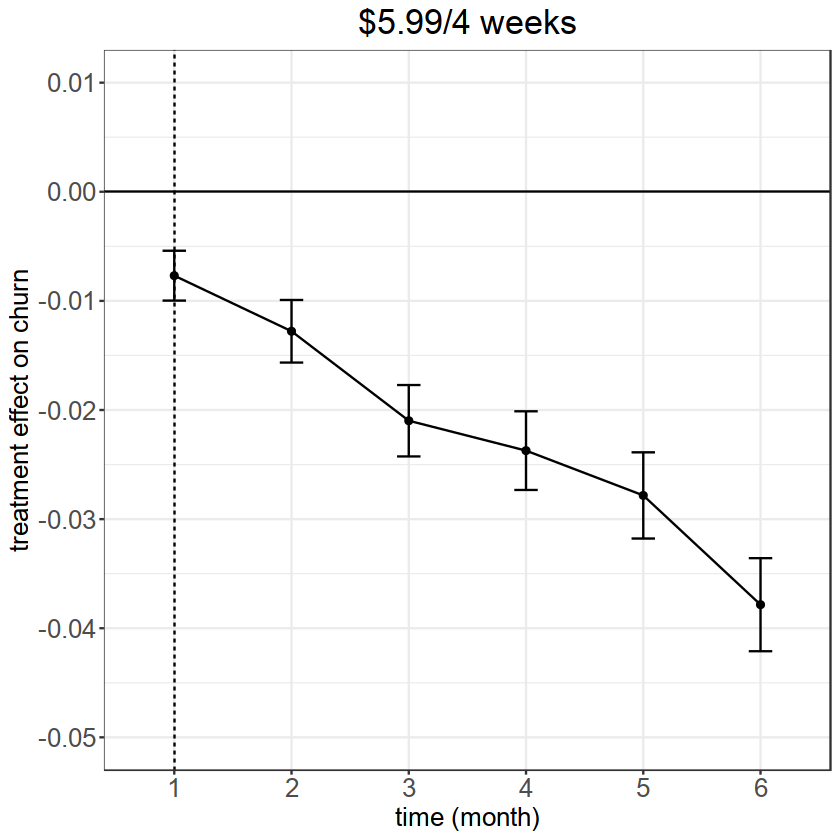

In [33]:
ggplot(att2, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=1, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_y_continuous(breaks=seq(-0.05,0.01,0.01),limits=c(-0.05,0.01)) + 
ggtitle('$5.99/4 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [34]:
# $5.99/8 weeks vs. control

att2 = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2) = c('time','effect','se')

cond = c('$5.99/8 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    att2[i,2:3] = summary(lm(churn ~ condition, 
           data = data,
           weights = weights_att))$coefficients[2,1:2] 
    att2[i,1] = i
    
    
}

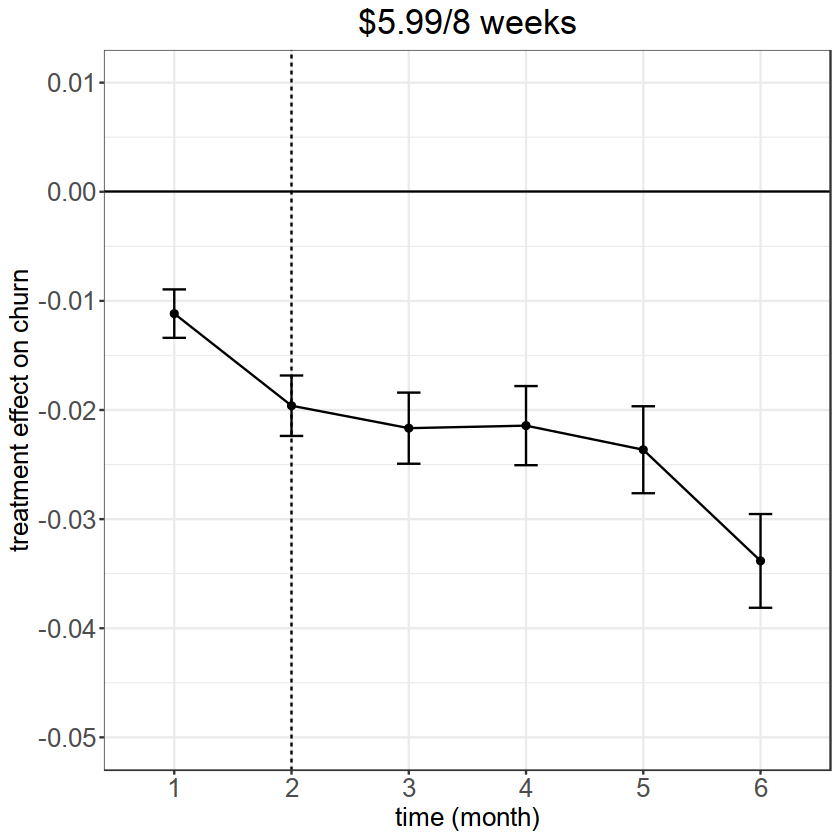

In [35]:
ggplot(att2, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_y_continuous(breaks=seq(-0.05,0.01,0.01),limits=c(-0.05,0.01)) + 
ggtitle('$5.99/8 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [36]:
# gift card vs. control

att2 = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2) = c('time','effect','se')

cond = c('gift card','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    att2[i,2:3] = summary(lm(churn ~ condition, 
           data = data,
           weights = weights_att))$coefficients[2,1:2] 
    att2[i,1] = i
    
    
}

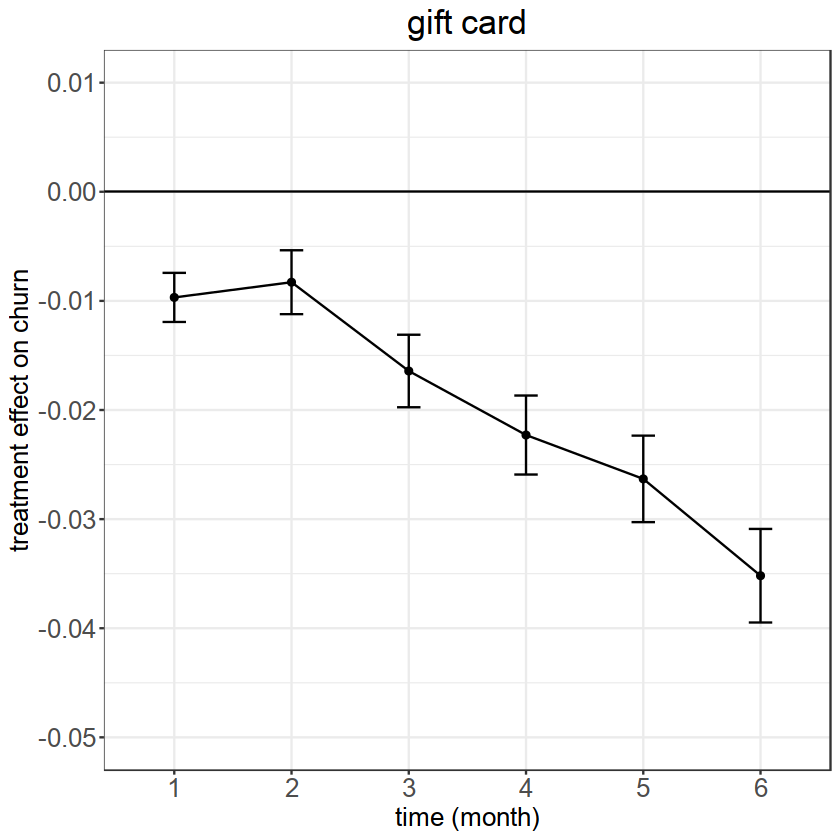

In [37]:
ggplot(att2, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_y_continuous(breaks=seq(-0.05,0.01,0.01),limits=c(-0.05,0.01)) + 
ggtitle('gift card')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [38]:
# thank you email only vs. control

att2 = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2) = c('time','effect','se')

cond = c('thank you email only','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    att2[i,2:3] = summary(lm(churn ~ condition, 
           data = data,
           weights = weights_att))$coefficients[2,1:2] 
    att2[i,1] = i
    
    
}

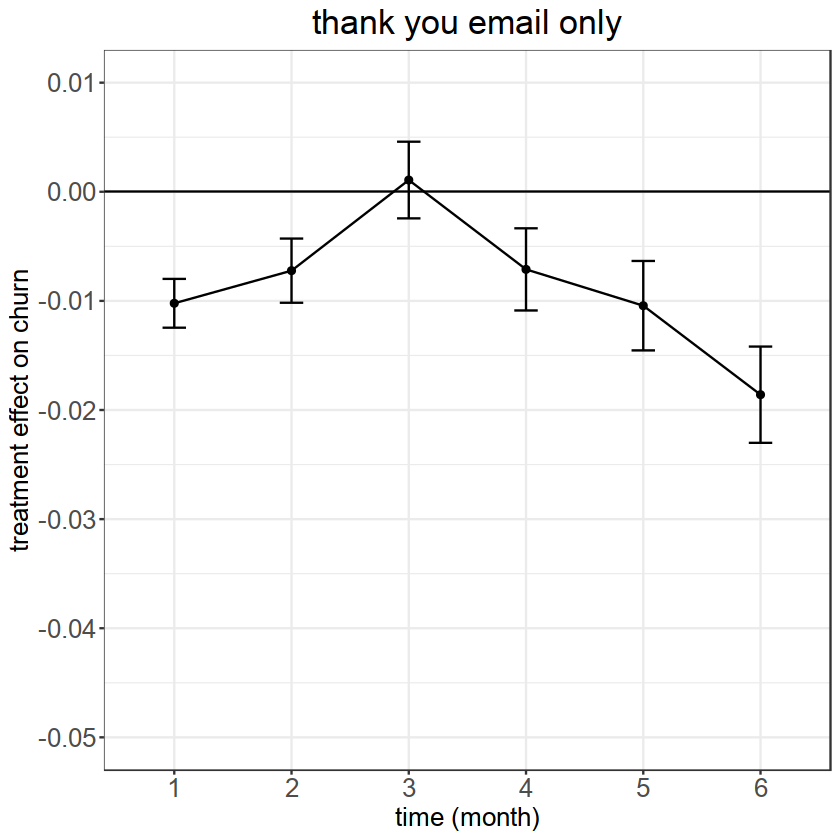

In [39]:
ggplot(att2, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_y_continuous(breaks=seq(-0.05,0.01,0.01),limits=c(-0.05,0.01)) + 
ggtitle('thank you email only')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on churn') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

#### figure D.8: treatment effects on revenue

In [40]:
start_date = as.Date('2019-07-15')
last_update = as.Date('2020-02-11')

regular = 6.93 # regular price
discounted = 4.99 # discounted price 

In [41]:
# $3.99/8 weeks vs. control

att2_rev = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2_rev) = c('time','effect','se')

cond = c('$3.99/8 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = case_when(
    
    churn == 0 & treated == 0 ~ regular/7*as.numeric(last_update-start_date),
    churn == 1 & treated == 0 ~ regular/7*as.numeric(last_stop_date-start_date),
    
    churn == 0 & condition == '$3.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+3.99*8,
    churn == 0 & condition == '$4.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+4.99*8,
    churn == 0 & condition == '$5.99/4 weeks' ~ regular/7*as.numeric(last_update-start_date-7*4)+5.99*4,
    churn == 0 & condition == '$5.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+5.99*8,
    churn == 0 & condition == 'gift card' ~ regular/7*as.numeric(last_update-start_date)-20,
    churn == 0 & condition == 'thank you email only' ~ regular/7*as.numeric(last_update-start_date),
    
    churn == 1 & condition == '$3.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+3.99*8,
                                                      3.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$4.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+4.99*8,
                                                      4.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/4 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*4)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*4)+5.99*4,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+5.99*8,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == 'gift card' ~ regular/7*as.numeric(last_stop_date-start_date)-20,
    churn == 1 & condition == 'thank you email only' ~ regular/7*as.numeric(last_stop_date-start_date)))
    
    att2_rev[i,2:3] = summary(lm(rev ~ condition, 
           data = data, 
           weights = weights_att))$coefficients[2,1:2] 
    att2_rev[i,1] = i
    
    
}

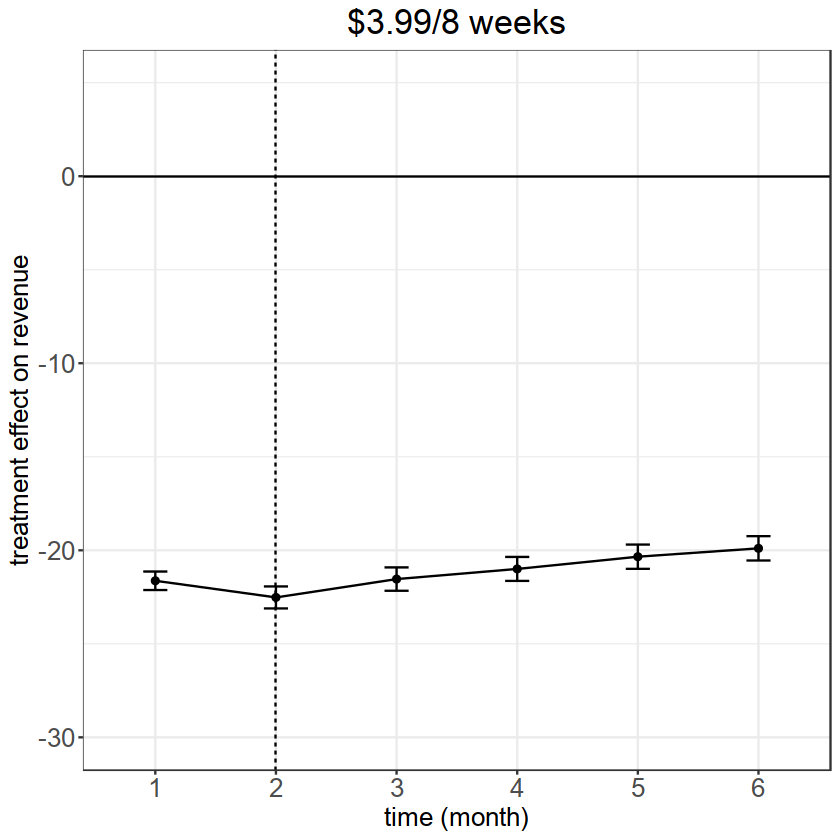

In [42]:
ggplot(att2_rev, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
ylim(c(-30,5))+ 
ggtitle('$3.99/8 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [43]:
# $4.99/8 weeks vs. control

att2_rev = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2_rev) = c('time','effect','se')

cond = c('$4.99/8 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = case_when(
    
    churn == 0 & treated == 0 ~ regular/7*as.numeric(last_update-start_date),
    churn == 1 & treated == 0 ~ regular/7*as.numeric(last_stop_date-start_date),
    
    churn == 0 & condition == '$3.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+3.99*8,
    churn == 0 & condition == '$4.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+4.99*8,
    churn == 0 & condition == '$5.99/4 weeks' ~ regular/7*as.numeric(last_update-start_date-7*4)+5.99*4,
    churn == 0 & condition == '$5.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+5.99*8,
    churn == 0 & condition == 'gift card' ~ regular/7*as.numeric(last_update-start_date)-20,
    churn == 0 & condition == 'thank you email only' ~ regular/7*as.numeric(last_update-start_date),
    
    churn == 1 & condition == '$3.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+3.99*8,
                                                      3.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$4.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+4.99*8,
                                                      4.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/4 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*4)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*4)+5.99*4,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+5.99*8,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == 'gift card' ~ regular/7*as.numeric(last_stop_date-start_date)-20,
    churn == 1 & condition == 'thank you email only' ~ regular/7*as.numeric(last_stop_date-start_date)))
    
    att2_rev[i,2:3] = summary(lm(rev ~ condition, 
           data = data, 
           weights = weights_att))$coefficients[2,1:2] 
    att2_rev[i,1] = i
    
    
}



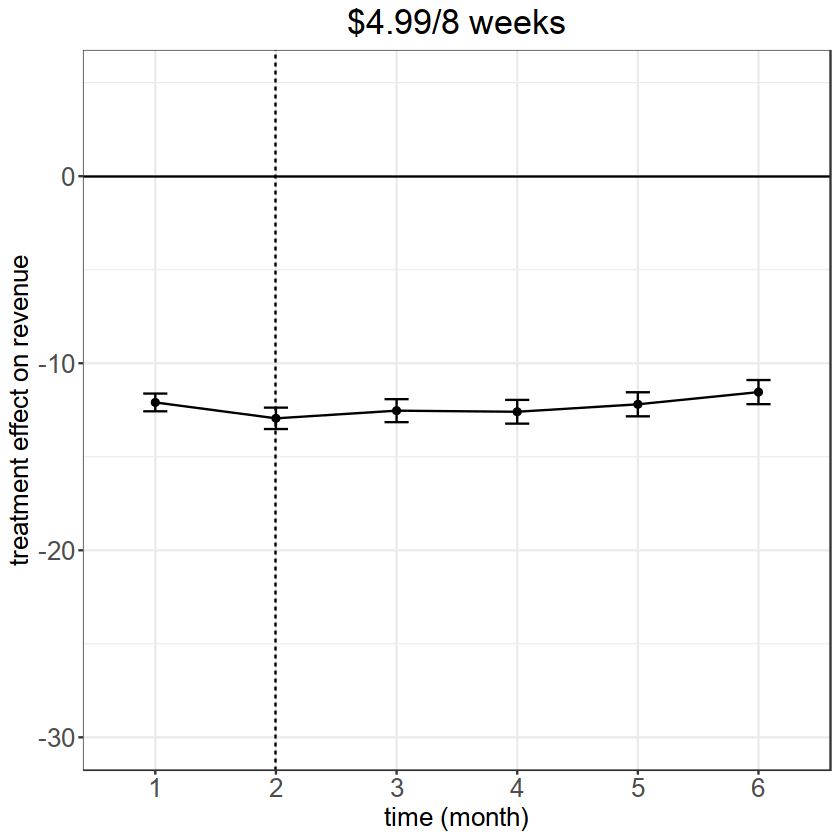

In [44]:
ggplot(att2_rev, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
ylim(c(-30,5))+ 
ggtitle('$4.99/8 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [45]:
# $5.99/4 weeks vs. control

att2_rev = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2_rev) = c('time','effect','se')

cond = c('$5.99/4 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = case_when(
    
    churn == 0 & treated == 0 ~ regular/7*as.numeric(last_update-start_date),
    churn == 1 & treated == 0 ~ regular/7*as.numeric(last_stop_date-start_date),
    
    churn == 0 & condition == '$3.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+3.99*8,
    churn == 0 & condition == '$4.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+4.99*8,
    churn == 0 & condition == '$5.99/4 weeks' ~ regular/7*as.numeric(last_update-start_date-7*4)+5.99*4,
    churn == 0 & condition == '$5.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+5.99*8,
    churn == 0 & condition == 'gift card' ~ regular/7*as.numeric(last_update-start_date)-20,
    churn == 0 & condition == 'thank you email only' ~ regular/7*as.numeric(last_update-start_date),
    
    churn == 1 & condition == '$3.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+3.99*8,
                                                      3.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$4.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+4.99*8,
                                                      4.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/4 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*4)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*4)+5.99*4,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+5.99*8,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == 'gift card' ~ regular/7*as.numeric(last_stop_date-start_date)-20,
    churn == 1 & condition == 'thank you email only' ~ regular/7*as.numeric(last_stop_date-start_date)))
    
    att2_rev[i,2:3] = summary(lm(rev ~ condition, 
           data = data, 
           weights = weights_att))$coefficients[2,1:2] 
    att2_rev[i,1] = i
    
    
}



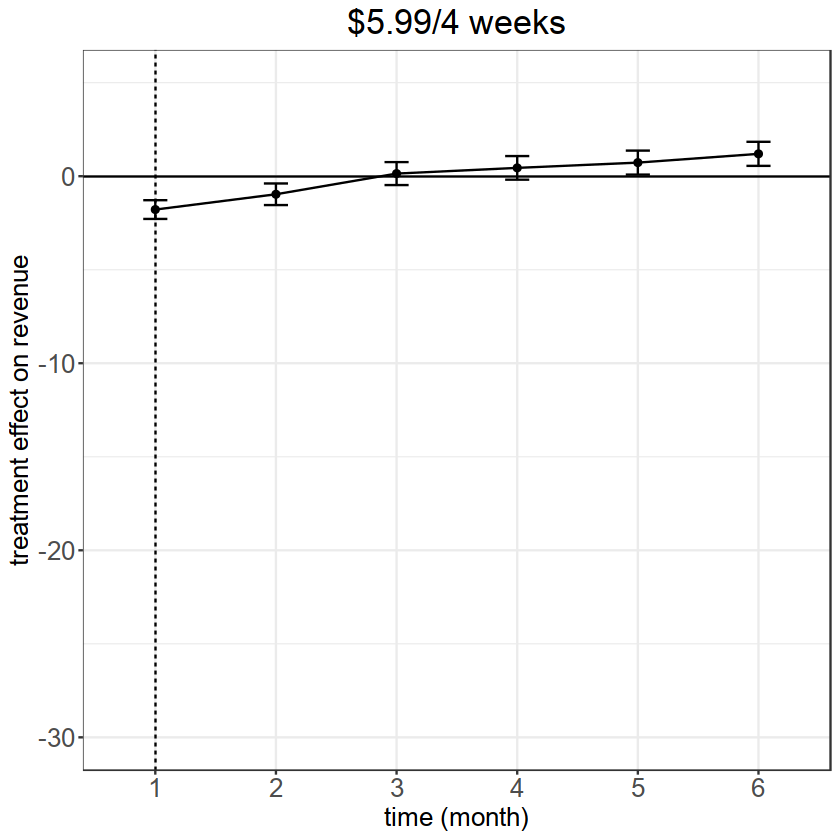

In [46]:
ggplot(att2_rev, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=1, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
ylim(c(-30,5))+ 
ggtitle('$5.99/4 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [47]:
# $5.99/8 weeks vs. control

att2_rev = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2_rev) = c('time','effect','se')

cond = c('$5.99/8 weeks','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = case_when(
    
    churn == 0 & treated == 0 ~ regular/7*as.numeric(last_update-start_date),
    churn == 1 & treated == 0 ~ regular/7*as.numeric(last_stop_date-start_date),
    
    churn == 0 & condition == '$3.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+3.99*8,
    churn == 0 & condition == '$4.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+4.99*8,
    churn == 0 & condition == '$5.99/4 weeks' ~ regular/7*as.numeric(last_update-start_date-7*4)+5.99*4,
    churn == 0 & condition == '$5.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+5.99*8,
    churn == 0 & condition == 'gift card' ~ regular/7*as.numeric(last_update-start_date)-20,
    churn == 0 & condition == 'thank you email only' ~ regular/7*as.numeric(last_update-start_date),
    
    churn == 1 & condition == '$3.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+3.99*8,
                                                      3.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$4.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+4.99*8,
                                                      4.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/4 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*4)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*4)+5.99*4,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+5.99*8,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == 'gift card' ~ regular/7*as.numeric(last_stop_date-start_date)-20,
    churn == 1 & condition == 'thank you email only' ~ regular/7*as.numeric(last_stop_date-start_date)))
    
    att2_rev[i,2:3] = summary(lm(rev ~ condition, 
           data = data, 
           weights = weights_att))$coefficients[2,1:2] 
    att2_rev[i,1] = i
    
    
}

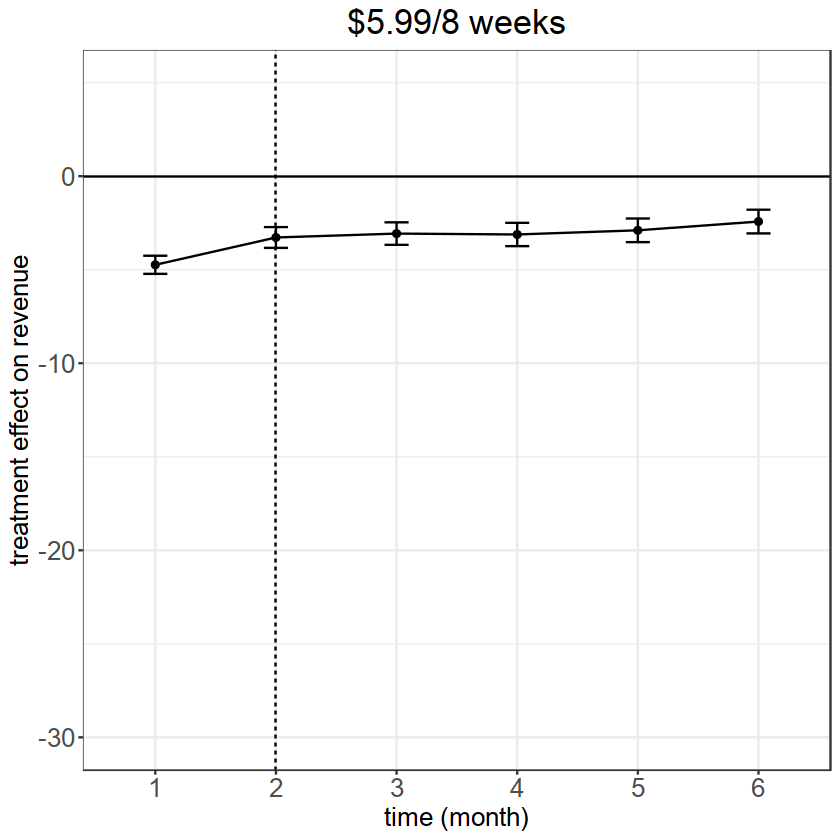

In [48]:
ggplot(att2_rev, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
geom_vline(xintercept=2, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
ylim(c(-30,5))+ 
ggtitle('$5.99/8 weeks')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [49]:
# gift card vs. control

att2_rev = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2_rev) = c('time','effect','se')

cond = c('gift card','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = case_when(
    
    churn == 0 & treated == 0 ~ regular/7*as.numeric(last_update-start_date),
    churn == 1 & treated == 0 ~ regular/7*as.numeric(last_stop_date-start_date),
    
    churn == 0 & condition == '$3.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+3.99*8,
    churn == 0 & condition == '$4.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+4.99*8,
    churn == 0 & condition == '$5.99/4 weeks' ~ regular/7*as.numeric(last_update-start_date-7*4)+5.99*4,
    churn == 0 & condition == '$5.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+5.99*8,
    churn == 0 & condition == 'gift card' ~ regular/7*as.numeric(last_update-start_date)-20,
    churn == 0 & condition == 'thank you email only' ~ regular/7*as.numeric(last_update-start_date),
    
    churn == 1 & condition == '$3.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+3.99*8,
                                                      3.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$4.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+4.99*8,
                                                      4.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/4 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*4)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*4)+5.99*4,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+5.99*8,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == 'gift card' ~ regular/7*as.numeric(last_stop_date-start_date)-20,
    churn == 1 & condition == 'thank you email only' ~ regular/7*as.numeric(last_stop_date-start_date)))
    
    att2_rev[i,2:3] = summary(lm(rev ~ condition, 
           data = data, 
           weights = weights_att))$coefficients[2,1:2] 
    att2_rev[i,1] = i
    
    
}

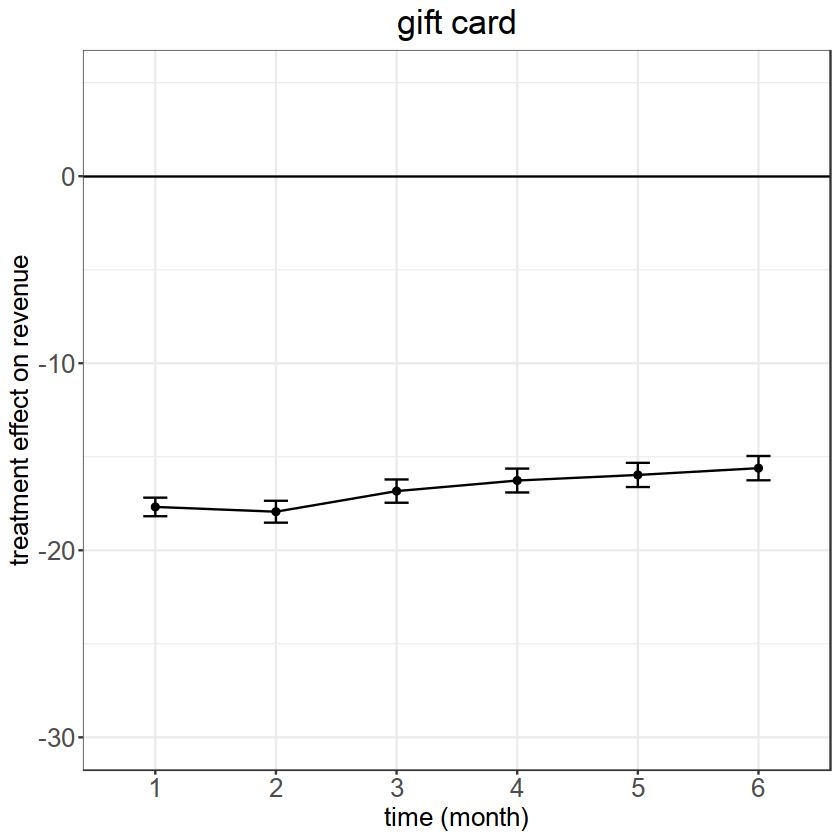

In [50]:
ggplot(att2_rev, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
scale_x_discrete(limits = factor(c(1:6))) + 
ylim(c(-30,5))+ 
ggtitle('gift card')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

In [51]:
# thank you email only vs. control

att2_rev = data.frame(matrix(ncol = 3, nrow = 0))
colnames(att2_rev) = c('time','effect','se')

cond = c('thank you email only','control')

for(i in 1:t) {
    
    data = df2
    
    data = filter(data, condition %in% cond)
    
    data$churn = ifelse(data$churn == 1, 
                    ifelse(data$last_stop_date >= (start_date + 30*i), 0, 1),0)
    
    data = data %>% mutate(rev = case_when(
    
    churn == 0 & treated == 0 ~ regular/7*as.numeric(last_update-start_date),
    churn == 1 & treated == 0 ~ regular/7*as.numeric(last_stop_date-start_date),
    
    churn == 0 & condition == '$3.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+3.99*8,
    churn == 0 & condition == '$4.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+4.99*8,
    churn == 0 & condition == '$5.99/4 weeks' ~ regular/7*as.numeric(last_update-start_date-7*4)+5.99*4,
    churn == 0 & condition == '$5.99/8 weeks' ~ regular/7*as.numeric(last_update-start_date-7*8)+5.99*8,
    churn == 0 & condition == 'gift card' ~ regular/7*as.numeric(last_update-start_date)-20,
    churn == 0 & condition == 'thank you email only' ~ regular/7*as.numeric(last_update-start_date),
    
    churn == 1 & condition == '$3.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+3.99*8,
                                                      3.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$4.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+4.99*8,
                                                      4.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/4 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*4)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*4)+5.99*4,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == '$5.99/8 weeks' ~ ifelse(as.numeric(last_stop_date-start_date-7*8)>0,
                                                      regular/7*as.numeric(last_stop_date-start_date-7*8)+5.99*8,
                                                      5.99/7*as.numeric(last_stop_date-start_date)),
    churn == 1 & condition == 'gift card' ~ regular/7*as.numeric(last_stop_date-start_date)-20,
    churn == 1 & condition == 'thank you email only' ~ regular/7*as.numeric(last_stop_date-start_date)))
    
    att2_rev[i,2:3] = summary(lm(rev ~ condition, 
           data = data, 
           weights = weights_att))$coefficients[2,1:2] 
    att2_rev[i,1] = i
    
    
}

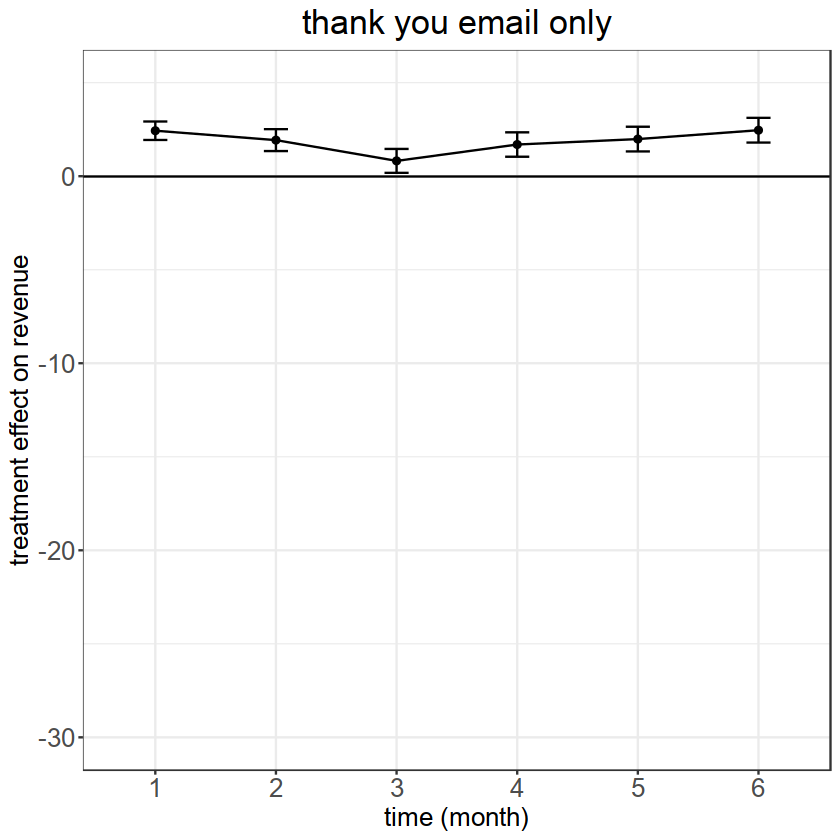

In [52]:
ggplot(att2_rev, 
       aes(time,effect)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=effect-2*se, ymax=effect+2*se), width=.2,
                 position=position_dodge(0.1)) + theme_bw() + 
geom_hline(yintercept=0) +
scale_x_discrete(limits = factor(c(1:6))) + 
ylim(c(-30,5))+ 
ggtitle('thank you email only')+ theme(plot.title = element_text(hjust = 0.5))+
xlab('time (month)') +
ylab('treatment effect on revenue') + 
scale_color_grey() + 
theme(axis.title = element_text(size = 15), 
      plot.title = element_text(size = 20), 
      axis.text = element_text(size = 15))  

#### table D.4: testing if users predicted to have bigger treatment effects based on the first experiment indeed have bigger treatment effects in the second experiment

In [53]:
model = lm(churn ~ condition*score_c, 
           data = df2, 
           weights = weights_att) 
summary(model) %>% print(digits=3)


Call:
lm(formula = churn ~ condition * score_c, data = df2, weights = weights_att)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-0.2261 -0.0202 -0.0160 -0.0131  0.9358 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.159849   0.002778   57.55  < 2e-16 ***
condition$3.99/8 weeks                -0.033476   0.003981   -8.41  < 2e-16 ***
condition$4.99/8 weeks                -0.037498   0.003996   -9.38  < 2e-16 ***
condition$5.99/4 weeks                -0.046309   0.003988  -11.61  < 2e-16 ***
condition$5.99/8 weeks                -0.042981   0.003980  -10.80  < 2e-16 ***
conditiongift card                    -0.042360   0.004006  -10.57  < 2e-16 ***
conditionthank you email only         -0.019336   0.003977   -4.86  1.2e-06 ***
score_c                               -0.014580   0.001439  -10.13  < 2e-16 ***
condition$3.99/8 weeks:score_c         0.011993   0.002067    5.80  6.6e-09 **

In [54]:
model = lm(rev ~ condition*score_c, 
           data = df2, 
           weights = weights_att) 
summary(model) %>% print(digits=3)


Call:
lm(formula = rev ~ condition * score_c, data = df2, weights = weights_att)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-121.90    0.79    0.81    0.88   12.15 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           120.8488     0.1929  626.60  < 2e-16 ***
condition$3.99/8 weeks                -22.0351     0.2764  -79.71  < 2e-16 ***
condition$4.99/8 weeks                -14.0544     0.2775  -50.65  < 2e-16 ***
condition$5.99/4 weeks                 -1.9970     0.2769   -7.21  5.6e-13 ***
condition$5.99/8 weeks                 -4.9927     0.2764  -18.07  < 2e-16 ***
conditiongift card                    -18.2159     0.2782  -65.49  < 2e-16 ***
conditionthank you email only           0.9067     0.2761    3.28  0.00102 ** 
score_c                                 0.2883     0.0999    2.89  0.00391 ** 
condition$3.99/8 weeks:score_c         -0.0688     0.1435   -0.48  0.63152    
condition$